### Thông tin sinh viên  
- ## Họ và tên: Nguyễn Văn Trường  
- ## Mã số sinh viên: 22022571  
- ## Lớp: *2425II_AIT3002_2*  
- ## Giảng viên hướng dẫn: *Trần Quốc Long*

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.models.segmentation as segmentation
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

import albumentations as A
from albumentations.pytorch import ToTensorV2

import random
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Tạo seed ngẫu nhiên để đảm bảo tính tái lập (reproducibility) trong huấn luyện mô hình

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(25)

## Tiền xử lý và tăng cường dữ liệu (data augmentations)
Trong bước này, ta xây dựng các phép biến đổi dữ liệu (transforms) để xử lý ảnh đầu vào trước khi đưa vào mô hình học sâu.
### Xây dựng tập trasform cho tập train và val.
### Tập Train (`train_transform`)

Để tăng khả năng tổng quát hoá (generalization) cho mô hình và hạn chế overfitting, ta sử dụng thư viện **Albumentations** – một thư viện mạnh mẽ và nhanh cho việc biến đổi ảnh. Cụ thể, các bước augmentation bao gồm:

| Loại biến đổi | Ý nghĩa | Tham số |
|---------------|--------|---------|
| `Resize(224, 224)` | Đưa ảnh về kích thước cố định 224x224 (chuẩn đầu vào cho nhiều mô hình CNN) | — |
| `HorizontalFlip(p=0.5)` | Lật ngang ảnh với xác suất 50% để mô phỏng sự đối xứng | `p=0.5` |
| `RandomBrightnessContrast(...)` | Thay đổi ngẫu nhiên độ sáng & tương phản | Giới hạn ±0.1 |
| `HueSaturationValue(...)` | Dịch chuyển tông màu (Hue), độ bão hoà (Saturation), và giá trị sáng (Value) | Hue ±5, Sat ±10 |
| `MotionBlur(blur_limit=3, p=0.05)` | Tạo hiệu ứng nhòe chuyển động nhẹ | Xác suất thấp |
| `Affine(...)` | Áp dụng các biến đổi hình học như zoom, xoay, dịch, shear nhẹ | Phạm vi nhỏ |
| `GaussNoise(...)` | Thêm nhiễu Gaussian nhẹ vào ảnh | Tạo tính ngẫu nhiên |
| `ImageCompression(...)` | Giả lập ảnh bị nén (mất chi tiết nhẹ) như JPEG | Chất lượng 90–100 |
| `Normalize(...)` | Chuẩn hóa ảnh theo thống kê của ImageNet (các mô hình pretrained yêu cầu) | Mean/Std chuẩn |
| `ToTensorV2()` | Chuyển ảnh sang tensor PyTorch để huấn luyện | — |

Tất cả những biến đổi này kết hợp giúp mô hình **“thấy” dữ liệu đa dạng hơn** từ một ảnh gốc → tăng hiệu suất dự đoán trên dữ liệu thật.

---

### Wrapper Class: `AlbumentationsTransform`

Đây là lớp trung gian giúp **đưa Albumentations hoạt động trong môi trường PyTorch**, tương tự như `torchvision.transforms`. Nó nhận ảnh đầu vào (dạng PIL Image), chuyển sang `numpy` rồi áp dụng transform của Albumentations.

---


In [3]:
# Tạo transform cho tập train (với augmentation)
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, image):
        # Chuyển PIL Image thành numpy array
        if hasattr(image, 'mode'):  # PIL Image
            image = np.array(image)
        
        # Apply albumentations transform
        transformed = self.transform(image=image)
        return transformed['image']

train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.2),
    A.MotionBlur(blur_limit=3, p=0.05),
    A.Affine(
        scale=(0.98, 1.02),
        translate_percent=(-0.02, 0.02),  
        rotate=(-5, 5),
        shear=(-2, 2),
        p=0.3
    ),
    A.GaussNoise(noise_scale_factor=0.1, p=0.1),
    A.ImageCompression(quality_range=(90, 100), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
]))

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

In [4]:
batch_size = 64
num_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-4

In [5]:
# Load dữ liệu
train_dataset = datasets.ImageFolder(root='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

Train dataset size: 8000
Validation dataset size: 1000
Number of classes: 2
Classes: ['Female', 'Male']


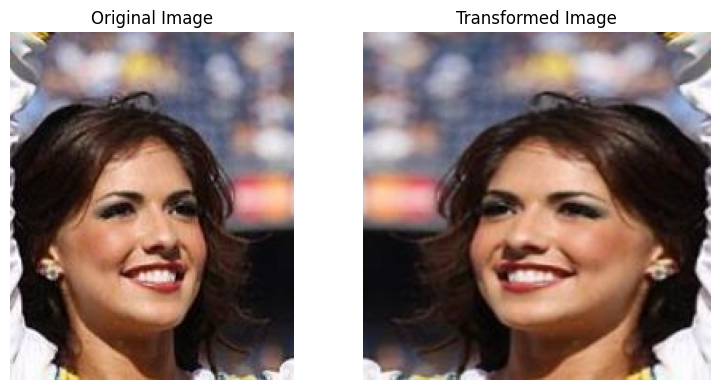

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
from torchvision.datasets import ImageFolder

visual_transform = AlbumentationsTransform(A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Affine(
        scale=(0.98, 1.02),
        translate_percent=(-0.02, 0.02),
        rotate=(-5, 5),
        shear=(-2, 2),
        p=0.3
    ),
    A.GaussNoise(noise_scale_factor=0.1, p=0.1),
    A.ImageCompression(quality_range=(90, 100), p=0.2),
]))

# Load ảnh
raw_dataset = ImageFolder(root='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train', transform=None)
image_path, _ = raw_dataset.samples[0] 
image_pil = Image.open(image_path).convert("RGB")  

# Apply transform
augmented_tensor = visual_transform(image_pil)
augmented_image = TF.to_pil_image(augmented_tensor)

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Transformed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Kiến trúc Mô hình: GenderClassificationPretrainedResnet

Trong bước này, em xây dựng một mô hình học sâu dựa trên các kiến trúc **ResNet pretrained** có sẵn trong thư viện `torchvision.models`, và tinh chỉnh (fine-tune) để thực hiện bài toán **phân loại giới tính (Gender Classification)**.

---

### Lý do chọn ResNet Pretrained

Các mô hình ResNet (Residual Networks) đã được huấn luyện trước trên bộ dữ liệu lớn **ImageNet**, do đó có khả năng **trích xuất đặc trưng mạnh mẽ** từ ảnh. Bằng cách tận dụng ResNet như một **feature extractor** và huấn luyện thêm các lớp phía sau, ta có thể đạt được kết quả tốt ngay cả với tập dữ liệu nhỏ hơn.

---

### Kiến trúc mô hình: `GenderClassificationPretrainedResnet`

Mô hình bao gồm:

#### 1. **Feature Extractor:**
- Gồm một mô hình ResNet đã được huấn luyện trước (`resnet18`, `resnet34`, `resnet50`, `resnet101`, hoặc `resnet152`).
- Lớp `fc` (fully connected) cuối cùng của ResNet được **loại bỏ** (`nn.Identity()`), để chỉ giữ lại phần trích xuất đặc trưng (`conv`, `bn`, `residual blocks`, ...).
- Kích thước vector đầu ra của ResNet sẽ là `num_features`.

#### 2. **Mạng phân loại phía sau:**
Gồm chuỗi các lớp fully connected (FC) xen kẽ với BatchNorm và Dropout để đảm bảo khả năng học và tránh overfitting:

```text


In [7]:
class GenderClassificationPretrainedResnet(nn.Module):
    def __init__(self, pretrained_model='resnet50'):
        super(GenderClassificationPretrainedResnet, self).__init__()
        # Chọn ResNet phù hợp
        if pretrained_model == 'resnet18':
            self.feature_extractor = models.resnet18(pretrained=True)
        elif pretrained_model == 'resnet34':
            self.feature_extractor = models.resnet34(pretrained=True)
        elif pretrained_model == 'resnet101':
            self.feature_extractor = models.resnet101(pretrained=True)
        elif pretrained_model == 'resnet152':
            self.feature_extractor = models.resnet152(pretrained=True)
        else:
            self.feature_extractor = models.resnet50(pretrained=True)
        
        num_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Identity()  # Loại bỏ lớp fully connected cuối

        # Thêm nhiều lớp fully connected và BatchNorm
        self.fc1 = nn.Linear(num_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Trích xuất đặc trưng từ pretrained model
        x = self.feature_extractor(x)

        # Thêm các lớp fully connected với BatchNorm và Dropout
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)

        return x

In [8]:
# Hàm train một epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy

# Hàm validation một epoch
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

## Hàm Huấn luyện Mô hình: `train_model`

Hàm `train_model()` là thành phần trung tâm trong pipeline huấn luyện mô hình phân loại giới tính.
### Chi tiết thuật toán huấn luyện

1. **Khởi tạo mô hình và Loss function:**
   - Mô hình được đưa lên thiết bị tính toán (`device`).
   - Loss function được sử dụng là `CrossEntropyLoss`, phù hợp cho bài toán phân loại nhị phân (2 classes: Male/Female).

2. **Freeze giai đoạn đầu:**
   - Trong `10 epoch` đầu tiên (`freeze_epochs`), toàn bộ các tham số của `feature_extractor` (tức phần ResNet) được **đóng băng** (`requires_grad = False`) nhằm chỉ huấn luyện phần fully connected.

3. **Optimizer và Scheduler:**
   - Dùng **AdamW** (hiệu quả hơn Adam trong regularization) để tối ưu.
   - Dùng `ReduceLROnPlateau`: nếu accuracy trên validation không cải thiện sau 3 epoch → giảm learning rate.

4. **Fine-tuning toàn bộ mô hình:**
   - Sau `freeze_epochs`, các layer trong ResNet được **mở khóa** để fine-tune toàn bộ mạng.
   - Optimizer được khởi tạo lại với toàn bộ tham số.

5. **Vòng lặp Epoch:**
   - Trong mỗi epoch:
     - Huấn luyện mô hình trên `train_loader` bằng hàm `train_epoch`.
     - Đánh giá mô hình trên `val_loader` bằng hàm `val_epoch`.
     - In kết quả loss và accuracy cho cả hai tập.
     - Cập nhật learning rate thông qua scheduler.
     - Nếu accuracy tốt hơn mọi lần trước, lưu trạng thái mô hình vào `save_path`.

6. **Tải lại mô hình tốt nhất:**
   - Sau khi huấn luyện xong, mô hình được **load lại từ file đã lưu**, đảm bảo rằng mô hình cuối cùng là mô hình tốt nhất về mặt validation accuracy.

---

### Ưu điểm

- Cho phép mô hình tận dụng kiến thức từ mô hình pretrained (transfer learning).
- Cân bằng giữa **tốc độ huấn luyện ban đầu** (freeze) và **hiệu suất cuối cùng** (fine-tune).
- Có cơ chế tự động điều chỉnh learning rate và lưu mô hình tốt nhất.
- Dễ dàng tái sử dụng và mở rộng với các kiến trúc khác nhau.

In [9]:
def train_model(model_class, train_loader, val_loader, device, num_epochs=20, learning_rate=0.001, weight_decay=1e-4, save_path="best_model.pth"):
    # Khởi tạo mô hình, loss function
    freeze_epochs = 10
    model = model_class.to(device)
    criterion = nn.CrossEntropyLoss()

    for param in model.feature_extractor.parameters():
        param.requires_grad = False

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1, verbose=True)

    best_val_accuracy = 0.0  # Khởi tạo giá trị val_accuracy tốt nhất

    # Vòng lặp huấn luyện
    for epoch in range(num_epochs):
        if epoch == freeze_epochs:
            for param in model.feature_extractor.parameters():
                param.requires_grad = True

            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1, verbose=True)

        # Huấn luyện trên tập train
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

        # Đánh giá trên tập validation
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

        # Cập nhật scheduler
        scheduler.step(val_accuracy)

        # Kiểm tra và lưu mô hình nếu val_accuracy cao hơn
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with Validation Accuracy: {val_accuracy:.2f}%\n")

    # Load mô hình tốt nhất
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded best model with Validation Accuracy: {best_val_accuracy:.2f}%")

    return model

In [10]:
trained_model = train_model(
    model_class=GenderClassificationPretrainedResnet('resnet50'),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    save_path='best_model_resnet.pth'
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1/50
Train Loss: 0.3327, Train Accuracy: 85.28%
Validation Loss: 0.2153, Validation Accuracy: 91.10%
--------------------------------------------------
New best model saved with Validation Accuracy: 91.10%



100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 2/50
Train Loss: 0.2392, Train Accuracy: 90.01%
Validation Loss: 0.1863, Validation Accuracy: 92.90%
--------------------------------------------------
New best model saved with Validation Accuracy: 92.90%



100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 3/50
Train Loss: 0.2260, Train Accuracy: 90.78%
Validation Loss: 0.1703, Validation Accuracy: 92.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 4/50
Train Loss: 0.2007, Train Accuracy: 91.41%
Validation Loss: 0.1674, Validation Accuracy: 93.50%
--------------------------------------------------
New best model saved with Validation Accuracy: 93.50%



100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 5/50
Train Loss: 0.2023, Train Accuracy: 91.44%
Validation Loss: 0.1706, Validation Accuracy: 94.00%
--------------------------------------------------
New best model saved with Validation Accuracy: 94.00%



100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 6/50
Train Loss: 0.1928, Train Accuracy: 92.00%
Validation Loss: 0.1578, Validation Accuracy: 94.40%
--------------------------------------------------
New best model saved with Validation Accuracy: 94.40%



100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 7/50
Train Loss: 0.1841, Train Accuracy: 92.54%
Validation Loss: 0.2241, Validation Accuracy: 92.20%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 8/50
Train Loss: 0.1805, Train Accuracy: 92.40%
Validation Loss: 0.1703, Validation Accuracy: 94.20%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch 9/50
Train Loss: 0.1773, Train Accuracy: 92.50%
Validation Loss: 0.1701, Validation Accuracy: 93.50%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


Epoch 10/50
Train Loss: 0.1702, Train Accuracy: 93.20%
Validation Loss: 0.1709, Validation Accuracy: 93.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


Epoch 11/50
Train Loss: 0.2349, Train Accuracy: 90.44%
Validation Loss: 0.1227, Validation Accuracy: 95.80%
--------------------------------------------------
New best model saved with Validation Accuracy: 95.80%



100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 12/50
Train Loss: 0.1551, Train Accuracy: 94.09%
Validation Loss: 0.1403, Validation Accuracy: 94.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 13/50
Train Loss: 0.1385, Train Accuracy: 94.85%
Validation Loss: 0.1737, Validation Accuracy: 93.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Epoch 14/50
Train Loss: 0.1166, Train Accuracy: 95.55%
Validation Loss: 0.0901, Validation Accuracy: 97.10%
--------------------------------------------------
New best model saved with Validation Accuracy: 97.10%



100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 15/50
Train Loss: 0.0990, Train Accuracy: 96.30%
Validation Loss: 0.0954, Validation Accuracy: 97.10%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Epoch 16/50
Train Loss: 0.0985, Train Accuracy: 96.01%
Validation Loss: 0.1138, Validation Accuracy: 95.50%
--------------------------------------------------


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


Epoch 17/50
Train Loss: 0.1096, Train Accuracy: 95.92%
Validation Loss: 0.1011, Validation Accuracy: 95.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 18/50
Train Loss: 0.0948, Train Accuracy: 96.59%
Validation Loss: 0.0955, Validation Accuracy: 96.70%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.50it/s]


Epoch 19/50
Train Loss: 0.0602, Train Accuracy: 97.88%
Validation Loss: 0.0655, Validation Accuracy: 97.70%
--------------------------------------------------
New best model saved with Validation Accuracy: 97.70%



100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 20/50
Train Loss: 0.0447, Train Accuracy: 98.39%
Validation Loss: 0.0688, Validation Accuracy: 97.70%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 21/50
Train Loss: 0.0390, Train Accuracy: 98.72%
Validation Loss: 0.0694, Validation Accuracy: 97.60%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 22/50
Train Loss: 0.0325, Train Accuracy: 98.99%
Validation Loss: 0.0711, Validation Accuracy: 97.60%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 23/50
Train Loss: 0.0345, Train Accuracy: 98.94%
Validation Loss: 0.0717, Validation Accuracy: 98.30%
--------------------------------------------------
New best model saved with Validation Accuracy: 98.30%



100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 24/50
Train Loss: 0.0312, Train Accuracy: 98.97%
Validation Loss: 0.0715, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 25/50
Train Loss: 0.0285, Train Accuracy: 99.03%
Validation Loss: 0.0743, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


Epoch 26/50
Train Loss: 0.0336, Train Accuracy: 98.94%
Validation Loss: 0.0731, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 27/50
Train Loss: 0.0289, Train Accuracy: 99.15%
Validation Loss: 0.0795, Validation Accuracy: 97.40%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 28/50
Train Loss: 0.0238, Train Accuracy: 99.36%
Validation Loss: 0.0744, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


Epoch 29/50
Train Loss: 0.0219, Train Accuracy: 99.34%
Validation Loss: 0.0767, Validation Accuracy: 97.70%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch 30/50
Train Loss: 0.0220, Train Accuracy: 99.26%
Validation Loss: 0.0781, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 31/50
Train Loss: 0.0220, Train Accuracy: 99.34%
Validation Loss: 0.0762, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 32/50
Train Loss: 0.0227, Train Accuracy: 99.39%
Validation Loss: 0.0808, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


Epoch 33/50
Train Loss: 0.0178, Train Accuracy: 99.39%
Validation Loss: 0.0779, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 34/50
Train Loss: 0.0206, Train Accuracy: 99.40%
Validation Loss: 0.0763, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 35/50
Train Loss: 0.0255, Train Accuracy: 99.19%
Validation Loss: 0.0803, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch 36/50
Train Loss: 0.0211, Train Accuracy: 99.31%
Validation Loss: 0.0765, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 37/50
Train Loss: 0.0179, Train Accuracy: 99.42%
Validation Loss: 0.0766, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 38/50
Train Loss: 0.0198, Train Accuracy: 99.38%
Validation Loss: 0.0788, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


Epoch 39/50
Train Loss: 0.0221, Train Accuracy: 99.26%
Validation Loss: 0.0780, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 40/50
Train Loss: 0.0200, Train Accuracy: 99.46%
Validation Loss: 0.0781, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 41/50
Train Loss: 0.0189, Train Accuracy: 99.53%
Validation Loss: 0.0767, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Epoch 42/50
Train Loss: 0.0222, Train Accuracy: 99.44%
Validation Loss: 0.0788, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Epoch 43/50
Train Loss: 0.0191, Train Accuracy: 99.42%
Validation Loss: 0.0755, Validation Accuracy: 98.00%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Epoch 44/50
Train Loss: 0.0223, Train Accuracy: 99.41%
Validation Loss: 0.0778, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 45/50
Train Loss: 0.0165, Train Accuracy: 99.50%
Validation Loss: 0.0760, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch 46/50
Train Loss: 0.0222, Train Accuracy: 99.24%
Validation Loss: 0.0766, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 47/50
Train Loss: 0.0238, Train Accuracy: 99.35%
Validation Loss: 0.0802, Validation Accuracy: 97.80%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 48/50
Train Loss: 0.0224, Train Accuracy: 99.31%
Validation Loss: 0.0806, Validation Accuracy: 97.90%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 49/50
Train Loss: 0.0239, Train Accuracy: 99.30%
Validation Loss: 0.0799, Validation Accuracy: 97.70%
--------------------------------------------------


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

Epoch 50/50
Train Loss: 0.0244, Train Accuracy: 99.31%
Validation Loss: 0.0763, Validation Accuracy: 98.00%
--------------------------------------------------
Loaded best model with Validation Accuracy: 98.30%


## Nhận Xét
- Mô hình học hiệu quả, không gặp lỗi huấn luyện rõ rệt.
- Có dấu hiệu **overfitting nhẹ** sau khoảng epoch 25.
- Tuy nhiên, sai số kiểm tra vẫn ổn định quanh mức ~98%.

---

## Kết Luận
- **Mô hình tốt nhất đạt:** `Validation Accuracy = 98.30%` tại **epoch 23**.
- Có thể sử dụng để kiểm thử hoặc triển khai thực tế.

---

### Phương Án Mở Rộng Trong Tương Lai: Bổ sung thêm tính năng Early Stopping giúp tiết kiệm thời gian training.

In [ ]:
class CustomTestDataset(Dataset):
    """
    Dataset tùy chỉnh cho tập test không có nhãn, chỉ cần tên file và ảnh.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(
            [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.jpg', '.png', '.jpeg'))]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

#Khởi tạo transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

#Tải dữ liệu
test_dataset = CustomTestDataset(root_dir='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Dự đoán và lưu kết quả
def predict_and_save_csv(model, test_loader, device, output_csv_path="predictions4.csv"):
    """
    Dự đoán nhãn cho tập test và lưu kết quả vào file CSV.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for images, filenames in tqdm(test_loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Lưu kết quả dự đoán
            for filename, label in zip(filenames, predicted.cpu().numpy()):
                id_ = os.path.splitext(filename)[0]  
                new_label = 1 - label

                results.append({"ID": id_, "label": int(new_label)})

    # Lưu kết quả vào CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

#Load mô hình
model = GenderClassificationPretrainedResnet('resnet50')
model.load_state_dict(torch.load('/kaggle/working/best_model_resnet.pth', map_location=device))
model = model.to(device)

#Thực hiện dự đoán
predict_and_save_csv(model, test_loader, device, output_csv_path="predictions4.csv")